<a href="https://colab.research.google.com/github/Westlifeohyeah/Byungjoonbae/blob/master/_main_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Example plotting

(256, 256)


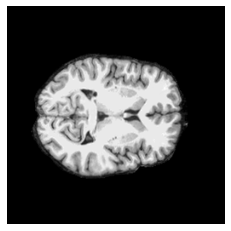

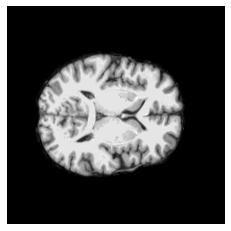

<Figure size 432x288 with 0 Axes>

In [ ]:
import mhd_utils_3d
import matplotlib.pyplot as plt
from medpy.io import load as ld
import numpy as np
data, dataload = ld('./data/Training/Healthy/OAS30001_MR_d0129.mhd')
data2, dataload = ld('./data/Training/Diseased/OAS30004_MR_d1101.mhd')
row, col = data.shape
print(data.shape)
fig = plt.imshow(data, cmap= 'gray')
plt.axis('off')
plt.figure()
fig2 = plt.imshow(data2, cmap= 'gray')
plt.axis('off')
plt.figure()
plt.show()

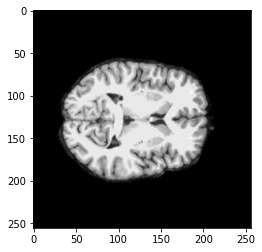

In [ ]:
data3 = np.concatenate((data, data2))
data3 = np.reshape(data3, (2,256,256))
fig2 = plt.imshow(data3[0,:,:], cmap= 'gray')

#data load

In [ ]:
import os
from os import walk
def dataload(root):
    count  = 0
    data = np.array([])
    for root, subdirs, files in os.walk(root):
        for file in files:
            if count == 0 and file.endswith(".mhd"):
                data, dataload = ld(root+'/'+file)
                row, col = data.shape
                count += 1
            elif count != 0 and file.endswith(".mhd"):
                data1, dataload = ld(root+'/'+file)
                data = np.concatenate((data,data1))
                count += 1
            else:
                continue
    data = np.reshape(data, (count, row, col))
    return data, count
Training_data_healthy, c11 = dataload('./data/Training/Healthy')
Training_data_diseased, c12 = dataload('./data/Training/Diseased')
Test_data_healthy, c21 = dataload('./data/Testing/Healthy')
Test_data_diseased, c22 = dataload('./data/Testing/Diseased')

In [ ]:
Training_data = np.concatenate((Training_data_healthy,Training_data_diseased))
Training_data = np.reshape(Training_data, (c11+c12, row, col , 1))
Training_label = np.concatenate((np.zeros((c11,1)), np.ones((c12,1))))
Test_data = np.concatenate((Test_data_healthy,Test_data_diseased))
Test_data = np.reshape(Test_data, (c21+c22, row, col , 1))
Test_label = np.concatenate((np.zeros((c21,1)), np.ones((c22,1))))

# Training

In [ ]:
import os
from os.path import isdir, join
import timeit
import argparse

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# avoid the odd behavior of pickle by importing under a different name
import pcanet as net
from utils import load_model, save_model, load_mnist, set_device


'''parser = argparse.ArgumentParser(description="PCANet example")
parser.add_argument("--gpu", "-g", type=int, default=-1,
                    help="GPU ID (negative value indicates CPU)")

subparsers = parser.add_subparsers(dest="mode",
                                   help='Choice of train/test mode')
subparsers.required = True
train_parser = subparsers.add_parser("train")
train_parser.add_argument("--out", "-o", default="result",
                          help="Directory to output the result")

test_parser = subparsers.add_parser("test")
test_parser.add_argument("--pretrained-model", default="result",
                         dest="pretrained_model",
                         help="Directory containing the trained model")

args = parser.parse_args()'''


def train(train_set):
    images_train, y_train = train_set
    print(images_train.shape)
    print("Training PCANet")

    pcanet = net.PCANet(
        image_shape=256,
        filter_shape_l1=2, step_shape_l1=1, n_l1_output=3,
        filter_shape_l2=2, step_shape_l2=1, n_l2_output=3,
        filter_shape_pooling=2, step_shape_pooling=2
    )

    pcanet.validate_structure()

    t1 = timeit.default_timer()
    pcanet.fit(images_train)
    t2 = timeit.default_timer()

    train_time = t2 - t1

    t1 = timeit.default_timer()
    X_train = pcanet.transform(images_train)
    t2 = timeit.default_timer()

    transform_time = t2 - t1

    print("Training the classifier")

    classifier = SVC(C=10)
    classifier.fit(X_train, y_train)
    return pcanet, classifier


def test(pcanet, classifier, test_set):
    images_test, y_test = test_set

    X_test = pcanet.transform(images_test)
    y_pred = classifier.predict(X_test)
    return y_pred, y_test


train_set = (Training_data, Training_label)
test_set = (Test_data, Test_label)
pcanet, classifier = train(train_set)


(378, 256, 256, 1)
Training PCANet
Training the classifier


c:\users\qoqud\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


#Testing

In [ ]:
y_pred, y_test = test(pcanet, classifier, test_set)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy: {}".format(accuracy))

accuracy: 0.7551020408163265
